Here we test a variety of different "early" vectorizers and techniques. These include Count Vectorizers, Bag of Words, 
TFIDF (and all three with dimensionality reduction), and Word2Vec (W2V). 

Since W2V transforms an individual word into a vector rather than an entire sentance, we try a) averaging all the words 
in a sentance into a single vector & b) putting all the words into a matrix; then using these as inputs into our XGBoost 
algorithms. We then perform a series of the same tests, but with balanced labels.

Additionally, the Algorithm is kept constant accross all vectorizers - an XGBoost without any hyperparameter tunning. 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import gensim.parsing.preprocessing as gen_preproc

import spacy
nlp = spacy.load('en_core_web_sm')

import numpy as np
from gensim.models import FastText
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import TruncatedSVD

import xgboost as xgb

## Load & Process the Data
The same as we have previously. 

In [3]:
df = pd.read_csv( 'parsed_train.txt', sep='\t', header=None,
                   names=['label', 'text'] )
df.head()

,label,text
0,__label__4,The Rock is destined to be the 21st Century 's...
1,__label__5,The gorgeously elaborate continuation of `` Th...
2,__label__4,Singer/composer Bryan Adams contributes a slew...
3,__label__3,You 'd think by now America would have had eno...
4,__label__4,Yet the act is still charming here .


In [4]:
df['label'] = df['label'].apply(lambda x: int( x.replace("__label__", "") ) - 1 )

basicPreproc = [lambda x: x.lower(), gen_preproc.strip_tags, \
    gen_preproc.strip_punctuation, gen_preproc.strip_non_alphanum, \
    gen_preproc.strip_multiple_whitespaces] #, gen_preproc.strip_short, gen_preproc.remove_stopwords

df['basicProc'] = df['text'].apply(lambda x: ' '.join( gen_preproc.preprocess_string(x, basicPreproc)))
df['stemmed'] = df['basicProc'].apply(lambda x: gen_preproc.stem_text(x))
df['lemmatized'] = df['basicProc'].apply(lambda x: ' '.join( [token.lemma_ for token in nlp(x)] ) )

df.head()

,label,text,basicProc,stemmed,lemmatized
0,3,The Rock is destined to be the 21st Century 's...,the rock is destined to be the 21st century s ...,the rock is destin to be the 21st centuri s ne...,the rock be destine to be the 21st century s n...
1,4,The gorgeously elaborate continuation of `` Th...,the gorgeously elaborate continuation of the l...,the gorgeous elabor continu of the lord of the...,the gorgeously elaborate continuation of the l...
2,3,Singer/composer Bryan Adams contributes a slew...,singer composer bryan adams contributes a slew...,singer compos bryan adam contribut a slew of s...,singer composer bryan adams contribute a slew ...
3,2,You 'd think by now America would have had eno...,you d think by now america would have had enou...,you d think by now america would have had enou...,-PRON- d think by now america would have have ...
4,3,Yet the act is still charming here .,yet the act is still charming here,yet the act is still charm here,yet the act be still charm here


## Load our Vectorizers. 
We include some ngrams, and a max feature count that is below our total word count. We also test out SVD (Singular Value Decomposition) as a means of dimensionality reduction and how that affects our models; in theory it should map synonyms and such to eachother. 

Ngrams are unfortunately not likely to be well taken into account, phrases such as "not good" are just not likely to have high enough frequency to appear compared to the liklihood unigrams are repeated. For A more in-depth analysis higher order ngrams should be identified seperately from the unigrams. Additionally, there is no particular reason to do dimensionality reduction to length 300 vectors; if we were doing true pipeline testing this is one parameter we would definitely wish to vary and see how it affected the result. 

In [5]:
bowVec = CountVectorizer(binary=True, ngram_range=(1,2), min_df=2, max_features=5000)
cvVec = CountVectorizer(binary=False, ngram_range=(1,2), min_df=2, max_features=5000)
tfidfVec = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_features=5000)

In [6]:
bowSVD = TruncatedSVD(n_components=300)
cvSVD = TruncatedSVD(n_components=300)
tfidfSVD = TruncatedSVD(n_components=300)

In [7]:
bowDTM = bowVec.fit_transform(df['lemmatized'])
cvDTM = cvVec.fit_transform(df['lemmatized'])
tfidfDTM = tfidfVec.fit_transform(df['lemmatized'])

In [8]:
bow300DTM = bowSVD.fit_transform(bowDTM)
cv300DTM = cvSVD.fit_transform(cvDTM)
tfidf300DTM = tfidfSVD.fit_transform(tfidfDTM)

In [9]:
bowModel = xgb.XGBClassifier(use_label_encoder=False)
cvModel = xgb.XGBClassifier(use_label_encoder=False)
tfidfModel = xgb.XGBClassifier(use_label_encoder=False)
bowSVDModel = xgb.XGBClassifier(use_label_encoder=False)
cvSVDModel = xgb.XGBClassifier(use_label_encoder=False)
tfidfSVDModel = xgb.XGBClassifier(use_label_encoder=False)

In [10]:
bowModel.fit(bowDTM, df['label'])

[20:50:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [11]:
cvModel.fit(cvDTM, df['label'])

[20:50:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [24]:
tfidfModel.fit(tfidfDTM, df['label'])

[20:52:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [27]:
bowSVDModel.fit(bow300DTM, df['label'])

[20:53:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [13]:
cvSVDModel.fit(cv300DTM, df['label'])

[20:50:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [31]:
tfidfSVDModel.fit(tfidf300DTM, df['label'])

[20:54:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [14]:
test_df = pd.read_csv( 'parsed_test.txt', sep='\t', header=None,
                   names=['label', 'text'] )
test_df['label'] = test_df['label'].apply(lambda x: int( x.replace("__label__", "") ) - 1 )
test_df['basicProc'] = test_df['text'].apply(lambda x: ' '.join( gen_preproc.preprocess_string(x, basicPreproc)))
test_df['stemmed'] = test_df['basicProc'].apply(lambda x: gen_preproc.stem_text(x))
test_df['lemmatized'] = test_df['basicProc'].apply(lambda x: ' '.join( [token.lemma_ for token in nlp(x)] ) )

test_df.head()

,label,text,basicProc,stemmed,lemmatized
0,2,Effective but too-tepid biopic,effective but too tepid biopic,effect but too tepid biopic,effective but too tepid biopic
1,3,If you sometimes like to go to the movies to h...,if you sometimes like to go to the movies to h...,if you sometim like to go to the movi to have ...,if -PRON- sometimes like to go to the movie to...
2,4,"Emerges as something rare , an issue movie tha...",emerges as something rare an issue movie that ...,emerg as someth rare an issu movi that s so ho...,emerge as something rare an issue movie that s...
3,2,The film provides some great insight into the ...,the film provides some great insight into the ...,the film provid some great insight into the ne...,the film provide some great insight into the n...
4,4,Offers that rare combination of entertainment ...,offers that rare combination of entertainment ...,offer that rare combin of entertain and educ,offer that rare combination of entertainment a...


In [15]:
from sklearn.metrics import accuracy_score

In [16]:
Y_true = list( test_df['label'] )

In [17]:
testBowDTM = bowVec.transform( test_df['lemmatized'] )
testCvDTM = cvVec.transform( test_df['lemmatized'] )
testTfidfDTM = tfidfVec.transform( test_df['lemmatized'] )

In [18]:
testBowSvdDTM = bowSVD.transform( testBowDTM )
testCvSvdDTM = cvSVD.transform( testCvDTM )
testTfidfSvdDTM = tfidfSVD.transform( testTfidfDTM )

In [19]:
bow_Y_predict = bowModel.predict(testBowDTM)

In [20]:
cv_Y_predict = cvModel.predict(testCvDTM)

In [25]:
tfidf_Y_predict = tfidfModel.predict(testTfidfDTM)

In [28]:
bow_svd_Y_predict = bowSVDModel.predict(testBowSvdDTM)

In [29]:
cv_svd_Y_predict = cvSVDModel.predict(testCvSvdDTM)

In [32]:
tfidf_svd_Y_predict = tfidfSVDModel.predict(testTfidfSvdDTM)

In [33]:
print( accuracy_score(Y_true, bow_Y_predict) )
print( accuracy_score(Y_true, cv_Y_predict) )
print( accuracy_score(Y_true, tfidf_Y_predict) )
print( accuracy_score(Y_true, bow_svd_Y_predict) )
print( accuracy_score(Y_true, cv_svd_Y_predict) )
print( accuracy_score(Y_true, tfidf_svd_Y_predict) )

0.36877828054298645
0.36923076923076925
0.36425339366515835
0.3407239819004525
0.35158371040723985
0.33710407239819007


## Results

All non-SVD models had nearly identical accuracy to eachother! All SVD models were the same! It appears in this context that the specific kind of vectorization of the bunch did not impact things too much. It is surprising that SVD / Dimensionality Reduction made our results *worse*. It would definitely be worth exploring if this was true accross a different range of dimensions. 

Looking down at the confusion matrices, we can see there was a very large amount of miss-clasification towards our over-represented classes. We will later balance our classes to see how that changes the results. Note that the two confusion matrices are unnormalized then normalized, both for bag of words. The various other models confusion matrices look nearly identical, whether SVD or other models.

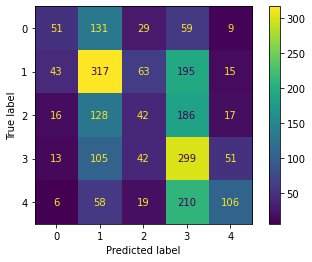

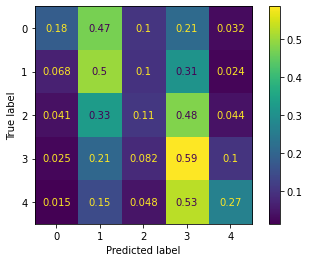

In [34]:
bowCM = confusion_matrix( Y_true, bow_Y_predict )
bowDisp = ConfusionMatrixDisplay( bowCM )
bowDisp.plot()

bowCMNorm = confusion_matrix( Y_true, bow_Y_predict, normalize='true' )
bowDispNorm = ConfusionMatrixDisplay( bowCMNorm )
bowDispNorm.plot()

# Balancing Classes

From our EDA notebook we had seen that classes 1 & 3 had significantly higher numbers of examples than the average. This caused our models to overpredict on those two classes. Here, we balance out all of our individual classes. Due to time constraints, we just cut all classes down to the same number of samples as our smallest class. This is obviously very unideal since it cuts our overall dataset size nearly in half. Ideally, we'd train via batches of balanced classes or do artifical data generation instead; this was just the fastest and simplest method of accounting for class imbalance, not the best.

In [35]:
g = df.groupby('label')
g = g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True))
g.head()

label                                               text  \
label                                                               
0     0      0  This little film is so slovenly done , so prim...   
      1      0  The entire film is one big excuse to play one ...   
      2      0  This is an ungainly movie , ill-fitting , with...   
      3      0   Every sequel you skip will be two hours gained .   
      4      0  Looks more like a travel-agency video targeted...   

                                                 basicProc  \
label                                                        
0     0  this little film is so slovenly done so primit...   
      1  the entire film is one big excuse to play one ...   
      2  this is an ungainly movie ill fitting with its...   
      3     every sequel you skip will be two hours gained   
      4  looks more like a travel agency video targeted...   

                                                   stemmed  \
label                                                        
0     0  thi littl film is so slovenli done so primit i...   
      1  the entir film is on big excus to plai on lewd...   
      2  thi is an ungainli movi ill fit with it elbow ...   
      3        everi sequel you skip will be two hour gain   
      4  look more like a travel agenc video target at ...   

                                                lemmatized  
label                                                       
0     0  this little film be so slovenly do so primitiv...  
      1  the entire film be one big excuse to play one ...  
      2  this be an ungainly movie ill fit with -PRON- ...  
      3     every sequel -PRON- skip will be two hour gain  
      4  look more like a travel agency video target at...

(array([1092., 1092., 1092., 1092., 1092.]),
 array([0, 1, 2, 3, 4, 5]),
 <BarContainer object of 5 artists>)

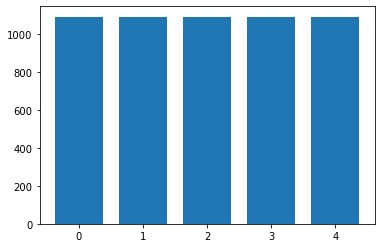

In [36]:
#Check to make sure our class balance worked.
plt.hist(list( g['label'] ), bins=[0,1,2,3,4,5], align='left', rwidth=0.75)

In [37]:
bowVecBalLabels = CountVectorizer(binary=True, ngram_range=(1,2), min_df=2, max_features=5000)
bowDTMBalLabels = bowVecBalLabels.fit_transform(g['lemmatized'])
bowModelBalLabels = xgb.XGBClassifier(use_label_encoder=False)
bowModelBalLabels.fit(bowDTMBalLabels, g['label'])

[21:00:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

0.3339366515837104


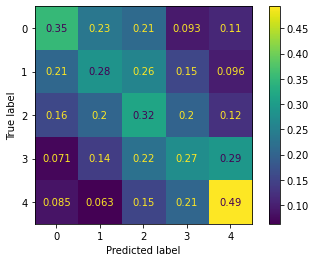

In [62]:
testBowBalLabelsDTM = bowVecBalLabels.transform( test_df['lemmatized'] )
bow_bal_labels_Y_predict = bowModelBalLabels.predict( testBowBalLabelsDTM )
print( accuracy_score(Y_true, bow_bal_labels_Y_predict) )

bowCMNormBalLabels = confusion_matrix( Y_true, bow_bal_labels_Y_predict, normalize='true' )
bowDispNormBalLabels = ConfusionMatrixDisplay( bowCMNormBalLabels )
bowDispNormBalLabels.plot()

# Word2Vec Time

In [38]:
df['tokenized'] = df['lemmatized'].apply(lambda x: x.split())
w2vModel = Word2Vec( df['tokenized'], size=100, window=5, min_count=3, workers=10)
df['num_words'] = df['tokenized'].apply(lambda x: len(x))
w2vClassificationModel = xgb.XGBClassifier(use_label_encoder=False)

In [39]:
vocab = list(w2vModel.wv.vocab)

def calc_vec(tokensLst):
    vecs = [w2vModel.wv[word] for word in tokensLst if word in vocab]
    if len(vecs) == 0:
        vecs = [np.zeros(100), np.zeros(100)]
    return sum(vecs) / max([len(tokensLst), 1])

df['w2vVectors'] = df['tokenized'].apply(lambda x: calc_vec(x))

g = df.groupby('label')
g = g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True))
g.head()

X = list( g['w2vVectors'] )

w2vClassificationModel.fit( X, g['label'] )

[21:00:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [40]:
test_df['tokenized'] = test_df['lemmatized'].apply(lambda x: x.split())
test_df['w2vVectors'] = test_df['tokenized'].apply(lambda x: calc_vec(x))
testXW2V_vecs = list( test_df['w2vVectors'] )

0.23031674208144795


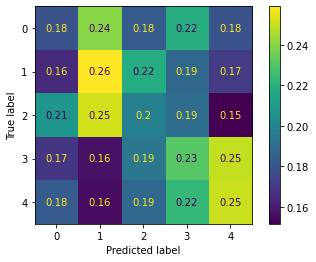

In [41]:
w2v_vecs_Y_predict = w2vClassificationModel.predict( testXW2V_vecs )
print( accuracy_score(Y_true, w2v_vecs_Y_predict) )

w2vConf_vecs = confusion_matrix( Y_true, w2v_vecs_Y_predict, normalize='true' )
w2v_vecs_Disp = ConfusionMatrixDisplay( w2vConf_vecs )
w2v_vecs_Disp.plot()

In [42]:
def calc_matrix(tokensLst, max_words=35):
    empty = np.zeros(100)
    vecs = [w2vModel.wv[word] for word in tokensLst if word in vocab]
    if len(vecs) < max_words:
        vecs += [empty for i in range(len(vecs), max_words)]
    else:
        vecs = vecs[:max_words]
    vecs = np.array(vecs).flatten()
    return vecs

df['w2vMatrices'] = df['tokenized'].apply(lambda x: calc_matrix(x))

In [43]:
g = df.groupby('label')
g = g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True))
g.head()

XMat = list( g['w2vMatrices'] )
w2vMatModel = xgb.XGBClassifier(use_label_encoder=False)
w2vMatModel.fit( XMat, g['label'] )

[21:03:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

0.267420814479638


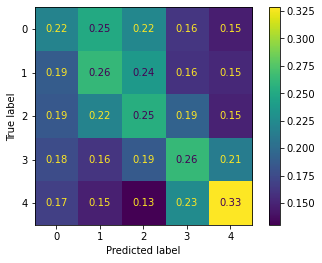

In [44]:
test_df['w2vMatrices'] = test_df['tokenized'].apply(lambda x: calc_matrix(x))
testMatX = list( test_df['w2vMatrices'] )

w2vMatPredictions = w2vMatModel.predict( testMatX )
print( accuracy_score(Y_true, w2vMatPredictions) )

w2vConf_Mats = confusion_matrix( Y_true, w2vMatPredictions, normalize='true' )
w2v_Mats_Disp = ConfusionMatrixDisplay( w2vConf_Mats )
w2v_Mats_Disp.plot()